In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf

%matplotlib inline

Goal: predict if a pokémon is legendary or not

In [2]:
dataset = pd.read_csv("Pokemon.csv")

In [6]:
dataset.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [7]:
dataset

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


# Data cleaning

In [8]:
data_raw = dataset.copy()

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [10]:
dataset.isna().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

There are 386 rows in the dataset where the column 'Type 2' has NULL values, so there is no need to considerate it.
Also, the columns '#' and 'Name' won't help at the recognization as well, so they should be dropped.

In [11]:
dataset = dataset.drop(['#', 'Name', 'Type 2'], axis=1)

In [12]:
dataset['Legendary'] = dataset['Legendary'].astype(int)

# EDA
(exploratory data analysis)

In [13]:
dataset

,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,318,45,49,49,65,65,45,1,0
1,Grass,405,60,62,63,80,80,60,1,0
2,Grass,525,80,82,83,100,100,80,1,0
3,Grass,625,80,100,123,122,120,80,1,0
4,Fire,309,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...
795,Rock,600,50,100,150,100,150,50,6,1
796,Rock,700,50,160,110,160,110,110,6,1
797,Psychic,600,80,110,60,150,130,70,6,1
798,Psychic,680,80,160,60,170,130,80,6,1


In [14]:
numeric_columns = dataset.drop('Type 1', axis=1).columns 

Numeric columns will be the dataset without 'Type 1' column.

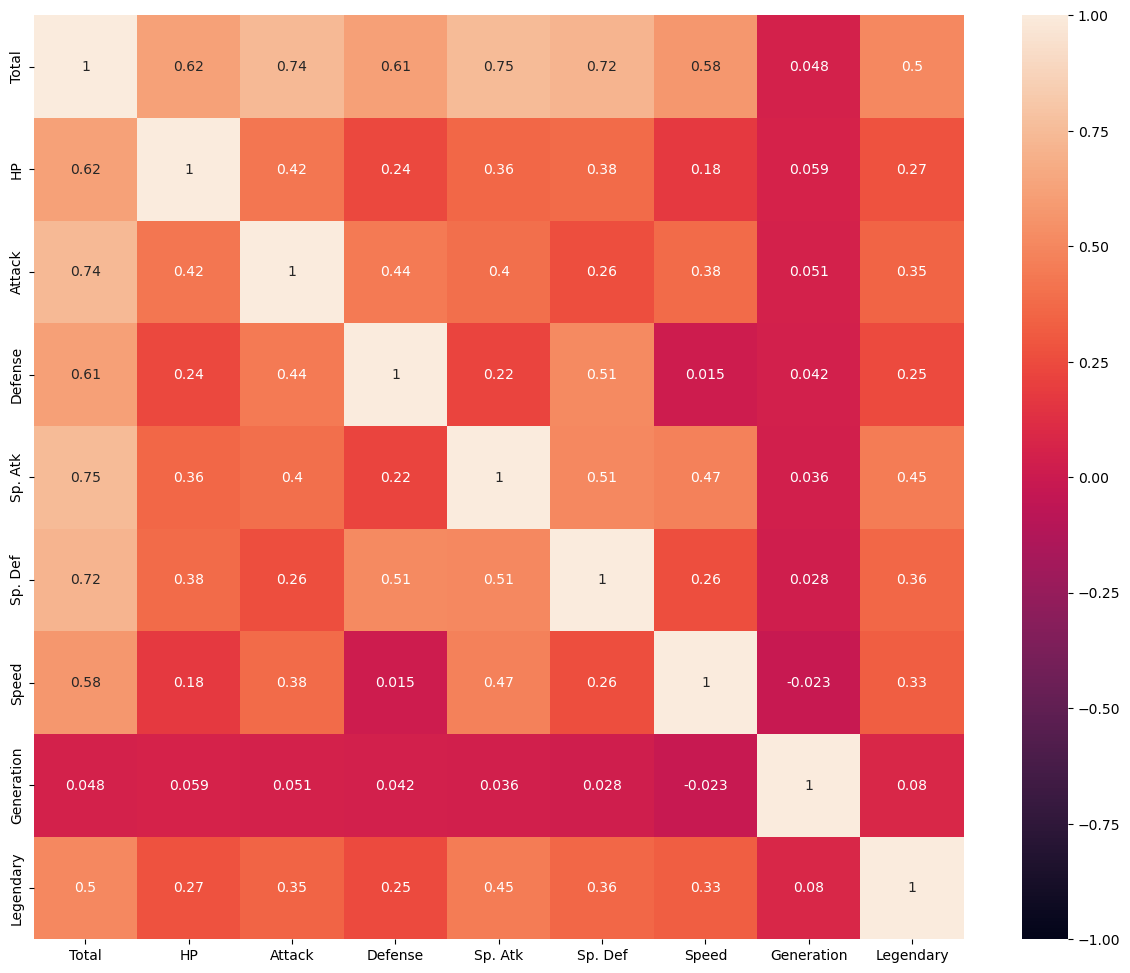

In [15]:
correlation_matrix = dataset[numeric_columns].corr() #generate correlation matrix

plt.figure(figsize=(15,12))
sns.heatmap(correlation_matrix, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

By the graph above, we can see that there is no feature that is super correlated (higher is 5, wich is 'Total') to the legendarie column. So, a combination of all features would be enough to predict if a poké is legendarie or not?

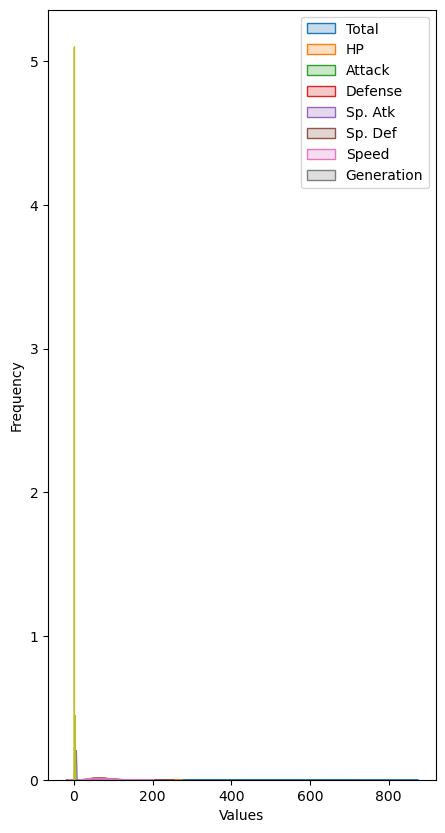

In [38]:
plt.figure(figsize=(5,10))
for column in numeric_columns:
    sns.kdeplot(dataset[column], shade=True)
plt.legend(['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']) 
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

The 'Total' and 'Generation' columns should not be included

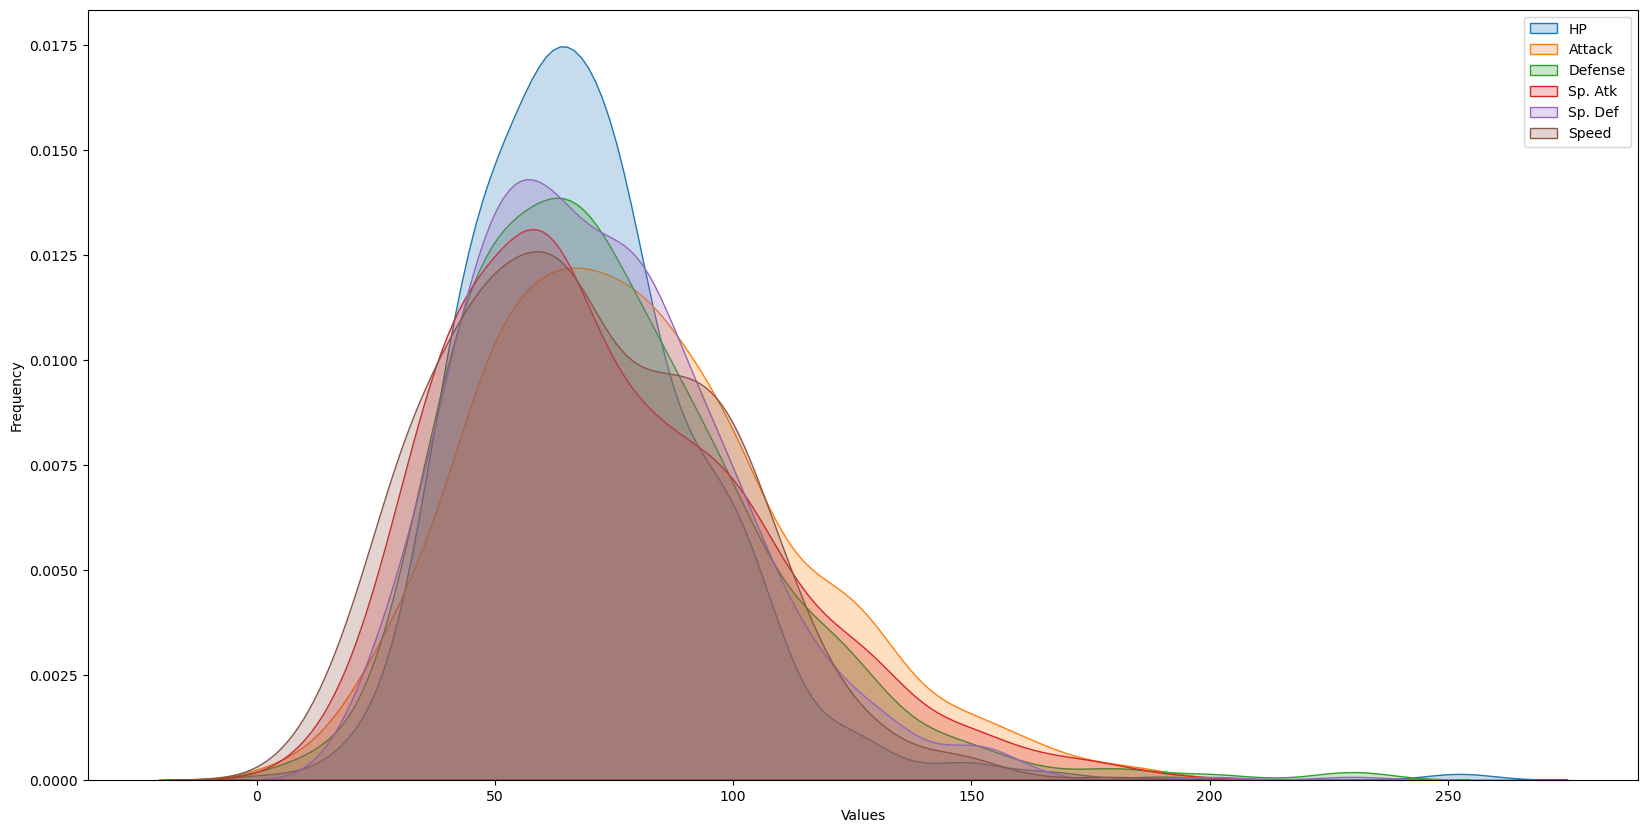

In [37]:
plt.figure(figsize=(20,10))
for column in ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    sns.kdeplot(dataset[column], shade=True)
plt.legend(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']) 
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

# Preprocessing

## Encoding

In [ ]:
#convert 'type 1' column to indicators
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [ ]:
dataset = onehot_encode(dataset, 'Type 1', 't')

In [95]:
dataset

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,t_Bug,...,t_Ghost,t_Grass,t_Ground,t_Ice,t_Normal,t_Poison,t_Psychic,t_Rock,t_Steel,t_Water
0,318,45,49,49,65,65,45,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,405,60,62,63,80,80,60,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,525,80,82,83,100,100,80,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,625,80,100,123,122,120,80,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,309,39,52,43,60,50,65,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50,6,1,0,...,0,0,0,0,0,0,0,1,0,0
796,700,50,160,110,160,110,110,6,1,0,...,0,0,0,0,0,0,0,1,0,0
797,600,80,110,60,150,130,70,6,1,0,...,0,0,0,0,0,0,1,0,0,0
798,680,80,160,60,170,130,80,6,1,0,...,0,0,0,0,0,0,1,0,0,0


## Splitting and Scaling

In [87]:
y = dataset['Legendary']
x = dataset.drop('Legendary', axis=1)

In [88]:
scaler = StandardScaler()

x = scaler.fit_transform(x)

# Training

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

In [116]:
inputs = tf.keras.Input(shape=(26,))
#dense layers: every neuron in the dense layer takes the input from all the other neurons of the previous layer
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

batch_size = 32
epochs = 19

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    #everytime the loss starts plateauing, the learning rate will be lowered
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)

Epoch 1/19
14/14 [==============================] - 1s 13ms/step - loss: 0.5037 - accuracy: 0.7991 - auc: 0.4107 - val_loss: 0.3945 - val_accuracy: 0.9018 - val_auc: 0.4190 - lr: 0.0010
Epoch 2/19
14/14 [==============================] - 0s 3ms/step - loss: 0.3051 - accuracy: 0.9129 - auc: 0.6174 - val_loss: 0.3176 - val_accuracy: 0.9018 - val_auc: 0.6557 - lr: 0.0010
Epoch 3/19
14/14 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9129 - auc: 0.8432 - val_loss: 0.2681 - val_accuracy: 0.9018 - val_auc: 0.8020 - lr: 0.0010
Epoch 4/19
14/14 [==============================] - 0s 5ms/step - loss: 0.1980 - accuracy: 0.9174 - auc: 0.9219 - val_loss: 0.2303 - val_accuracy: 0.9107 - val_auc: 0.8839 - lr: 0.0010
Epoch 5/19
14/14 [==============================] - 0s 3ms/step - loss: 0.1674 - accuracy: 0.9308 - auc: 0.9615 - val_loss: 0.2096 - val_accuracy: 0.9107 - val_auc: 0.9176 - lr: 0.0010
Epoch 6/19
14/14 [==============================] - 0s 3ms/step - loss: 0.

## Results

In [117]:
fig_loss = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'x': "Epoch", 'y':"Loss"},
    title="Loss over time"
)

fig_loss.show()

Now, we need the minimum of the validation loss (the red curve):

In [118]:
np.argmin(history.history['val_loss'])

18

In [119]:
##area under the roc curve
fig_auc = px.line (
    history.history,
    y=['auc', 'val_auc'],
    labels={'x': "Epoch", 'y':"AUC"},
    title="AUC overtime"
)

fig_auc.show()

In [120]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 1ms/step - loss: 0.0999 - accuracy: 0.9542 - auc: 0.9738


[0.09985364228487015, 0.9541666507720947, 0.9737776517868042]

# Post-training analysis

In [139]:
(model.predict(x_test) >= 0.5).astype(int)

8/8 [==============================] - 0s 786us/step


In [140]:
np.hstack((model.predict(x_test) >= 0.5).astype(int)) 

8/8 [==============================] - 0s 857us/step


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [141]:
predictions = (np.hstack((model.predict(x_test) >= 0.5).astype(int)) != y_test).astype(int)
predictions

8/8 [==============================] - 0s 929us/step


696    1
667    0
63     0
533    0
66     0
      ..
220    0
450    0
380    0
132    0
375    0
Name: Legendary, Length: 240, dtype: int32

The arrays that equals to 1 are the incorrect ones

In [142]:
predictions.sum()

11

In [138]:
1 - 11/240

0.9541666666666667

In [149]:
predictions = (np.hstack((model.predict(x_test) >= 0.5).astype(int)) != y_test)

#indexes of mislabeled pokemons
mislabeled_indices = y_test[predictions].index

8/8 [==============================] - 0s 786us/step


In [150]:
data_raw.loc[mislabeled_indices, :]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
696,635,Hydreigon,Dark,Dragon,600,92,105,90,125,90,98,5,False
306,282,GardevoirMega Gardevoir,Psychic,Fairy,618,68,85,65,165,135,100,3,False
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
275,254,SceptileMega Sceptile,Grass,Dragon,630,70,110,75,145,85,145,3,False
715,648,MeloettaAria Forme,Normal,Psychic,600,100,77,77,128,128,90,5,False
409,373,SalamenceMega Salamence,Dragon,Flying,700,95,145,130,120,90,120,3,False
776,706,Goodra,Dragon,NaN,600,90,100,70,110,150,80,6,False
264,245,Suicune,Water,NaN,580,100,75,115,90,115,85,2,True
527,475,GalladeMega Gallade,Psychic,Fighting,618,68,165,95,65,115,110,4,False
196,181,AmpharosMega Ampharos,Electric,Dragon,610,90,95,105,165,110,45,2,False


## PCA
(principal component analysis)


### What's special about the mislabeled pokémons:


They are either mega evolutions or dragon types.

The original number of features of x was 26

In [160]:
#change of bases: take the 2 most important features and reduce it
pca = PCA(n_components=2)
data_reduced = pd.DataFrame(pca.fit_transform(dataset), columns = ["PC1", "PC2"])

In [161]:
data_reduced

,PC1,PC2
0,-125.860535,-5.210496
1,-32.131498,-5.769779
2,97.225136,-5.394538
3,206.065317,18.625769
4,-135.910526,-21.594064
...,...,...
795,179.904137,67.081536
796,290.419171,-20.944313
797,181.100238,-27.664645
798,269.322935,-37.485121


In [168]:
legendary_indices = dataset.query("Legendary == 1").index

mislabeled_legendary_indices = np.intersect1d(mislabeled_indices, legendary_indices)

<function matplotlib.pyplot.show(close=None, block=None)>

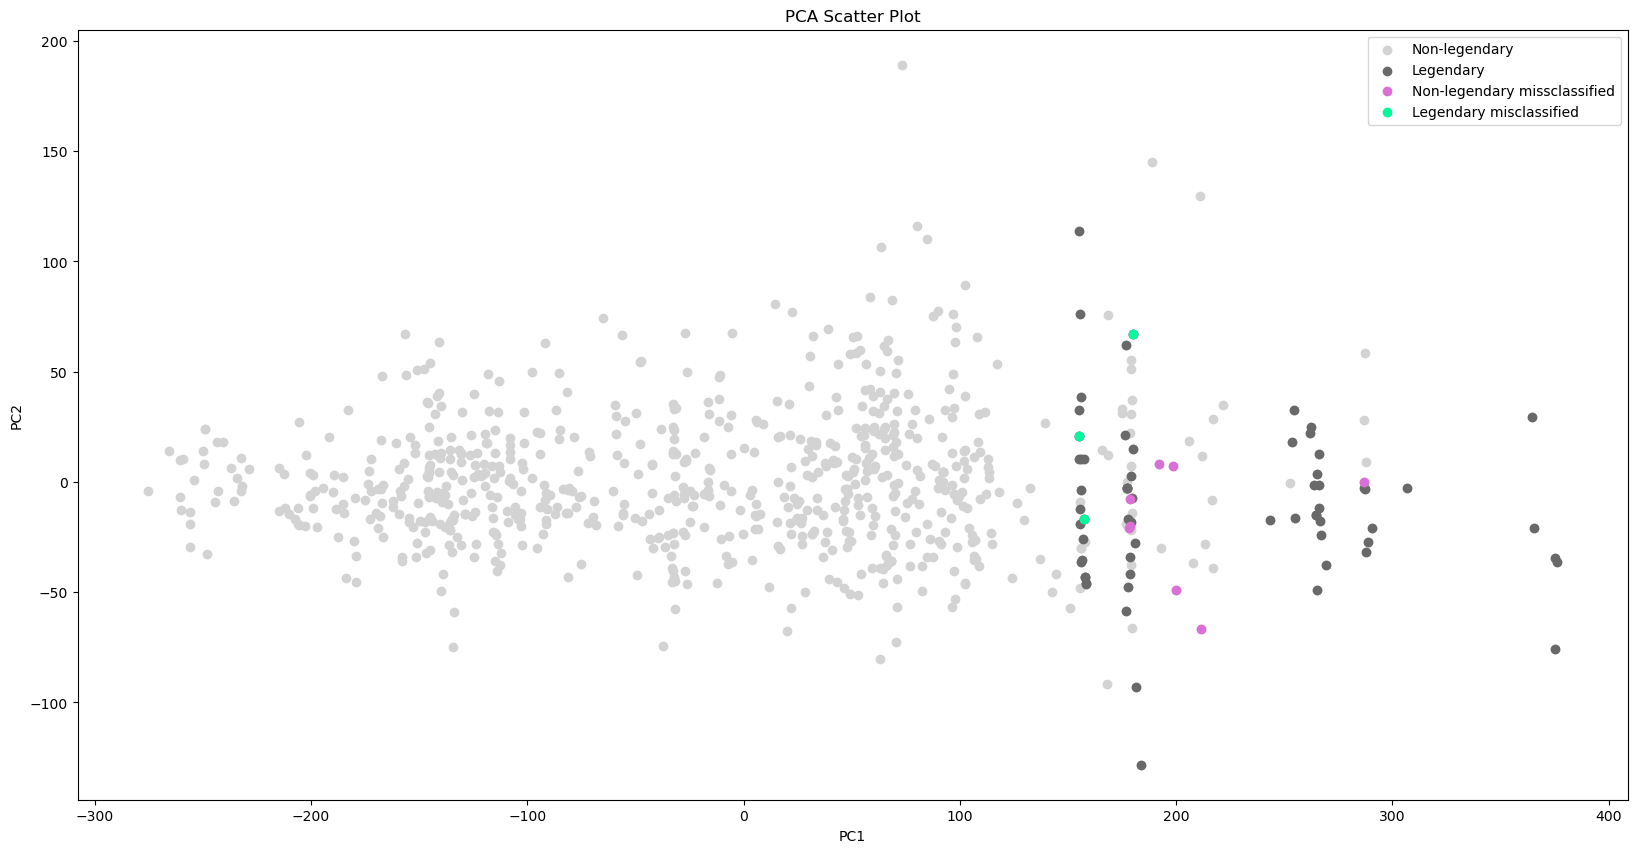

In [170]:
plt.figure(figsize=(20,10))
plt.scatter(data_reduced['PC1'], data_reduced['PC2'], c='lightgray')
plt.scatter(data_reduced.loc[legendary_indices, 'PC1'], data_reduced.loc[legendary_indices, 'PC2'], c='dimgray')
plt.scatter(data_reduced.loc[mislabeled_indices, 'PC1'], data_reduced.loc[mislabeled_indices, 'PC2'], c='orchid')
plt.scatter(data_reduced.loc[mislabeled_legendary_indices, 'PC1'], data_reduced.loc[mislabeled_legendary_indices, 'PC2'], c='mediumspringgreen')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(['Non-legendary', 'Legendary', 'Non-legendary missclassified', 'Legendary misclassified'])
plt.title("PCA Scatter Plot")
plt.show

# Conclusion

At PC1 around 150, the model did a great job by identifying legendaries. However, it had a hard time after that, since the rules for those pokémon are a little different.